In [1]:
#### basic example Jupyter notebook in support of Nowack et al., Atmospheric Measurement Techniques, 2021
#### written by Peer Nowack and Lev Konstantinovskiy
#### going through the case for NO2 sensor calibrations
#### first the four calibration algorithms are fitted
#### and then site transfers (Figures 7 and 8) are tested

In [2]:
#### Load Python 3 packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M, DotProduct
import scipy.stats
import scipy.optimize as spo
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
%matplotlib inline
from sklearn.model_selection import KFold

/home/peer/anaconda3/envs/airpublic_new/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [3]:
### import a few self-defined functions
### mostly for data loading and pre-processing
import functions_lev_peer as lp

In [4]:
### global parameter for MAD outlier removal
outlier_removal_threshold = 7
### names of predictor/calibration variables in .csv data file (data can be obtained from Hannah Gardiner, see Data Availability statement in AMT paper)
x_cols_in =  [ 'afewrk1', 'afeaux1',  'afewrk2', 'afeaux2', 'afewrk3', 'afeaux3', 'afept1k', 'isbwrk','isbaux', 'pm1hum','pm2hum','pm1tmp','pm2tmp', 'mics1', 'mics2' ]

In [5]:
### load raw CR7 and CR9 data - Air Public measurements
#### all done for sensor 19 for which we have the relevant data for site transfers
#### you will need to adapt the filepaths to the data
start_experiment_str_CR9 = '24/09/2019 00:00:00' 
start_experiment_CR9 = pd.to_datetime(start_experiment_str_CR9)
end_experiment_CR9 = pd.to_datetime('2020-01-19 10:59:00')
start_experiment_str_CR7 = '2018-10-21 21:30:54'
start_experiment_CR7 = pd.to_datetime(start_experiment_str_CR7)
end_experiment_CR7 = pd.to_datetime('2018-12-05 23:59:00')
all_ids = [19]
ids_to_analyse = all_ids
df_raw_CR9 = lp.read_raw('./data//airpublic_15jan2019_fromaug2019.csv', start_experiment=start_experiment_CR9, end_experiment=end_experiment_CR9, colocated_devices=ids_to_analyse)
df_raw_CR7 = lp.read_raw('./data/sensor_readings/from_airpublic/during cr7 colocation/hourly_averaged/airpublic_coloc_cr7_2018_full.csv', start_experiment=start_experiment_CR7, end_experiment=end_experiment_CR7, colocated_devices=ids_to_analyse)

/home/peer/anaconda3/envs/airpublic_new/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
print(df_raw_CR9.timestamp.min(),df_raw_CR9.timestamp.max())

2019-09-25 11:57:52.208417 2019-12-10 17:59:13.616985


In [7]:
print(df_raw_CR7.timestamp.min(),df_raw_CR7.timestamp.max())

2018-10-22 21:30:55.251403 2018-11-26 12:16:01.766375


In [8]:
### load LAQN CR9 reference data
### again you will need to adapt the filepaths
ds_kings_vol_CR9 = lp.load_kings('./data/cr9_2019.csv', start_experiment=start_experiment_CR9, end_experiment=end_experiment_CR9)
kings_prefix_CR9 = dict([(v, 'kings_'+v) for v in ds_kings_vol_CR9.data_vars])
ds_kings_vol_CR9.timestamp.to_dataframe().describe()

,timestamp
count,1864
unique,1864
top,2019-11-28 13:00:00
freq,1
first,2019-09-24 01:00:00
last,2019-12-10 16:00:00


In [9]:
### load LAQN reference data ('kings') for CR7
ds_kings_vol_CR7 = lp.load_kings('./data/cr7.csv', start_experiment=start_experiment_CR7, end_experiment=end_experiment_CR7)
kings_prefix_CR7 = dict([(v, 'kings_'+v) for v in ds_kings_vol_CR7.data_vars])
ds_kings_vol_CR7.timestamp.to_dataframe().describe()

,timestamp
count,1082
unique,1082
top,2018-11-29 10:00:00
freq,1
first,2018-10-21 22:00:00
last,2018-12-05 23:00:00


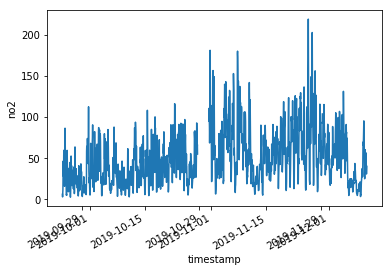

In [10]:
### note there is a gap in the LAQN measurements.
ds_kings_vol_CR9.no2.plot()

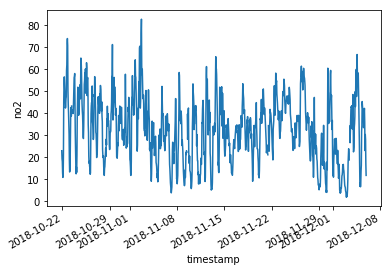

In [11]:
### note there is a gap in the LAQN measurements.
ds_kings_vol_CR7.no2.plot()

In [12]:
### joining CR9 datasets together

In [13]:
one_sensor_with_kings_CR9 = {}
for sensor_id in all_ids:
    print("Sensor %i" % sensor_id)
    print(start_experiment_CR9, end_experiment_CR9)    
    df_one_sensor_CR9 = df_raw_CR9[(df_raw_CR9.timestamp >= start_experiment_CR9) & (df_raw_CR9.timestamp <= end_experiment_CR9) & (df_raw_CR9.id == sensor_id)]
    print(" before clean %i rows" % len(df_one_sensor_CR9))
    df_clean_one_sensor_CR9, limits_dict = lp.remove_outliers_NO2(df_one_sensor_CR9, thresh=outlier_removal_threshold)
    print(" after clean %i rows" % len(df_clean_one_sensor_CR9))
    ds_CR9 = xr.Dataset.from_dataframe(df_clean_one_sensor_CR9.sort_values('timestamp').set_index('timestamp', 'id'))
    ds_mean_1h_CR9 = ds_CR9.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
    print(" %i hours" % len(ds_mean_1h_CR9.to_dataframe()))
    df_prepr_CR9 = lp.preprocess(ds_mean_1h_CR9.to_dataframe().reset_index(), start_experiment_CR9)
    ds_processed_CR9 = xr.Dataset.from_dataframe(df_prepr_CR9.set_index('timestamp', 'id'))
    ds_merged_CR9 = xr.merge([ds_kings_vol_CR9.rename(kings_prefix_CR9), ds_processed_CR9], join='inner')
    print("After merge %i readings" % len(ds_merged_CR9.to_dataframe()))
    one_sensor_with_kings_CR9[sensor_id] = ds_merged_CR9.to_dataframe()

Sensor 19
2019-09-24 00:00:00 2020-01-19 10:59:00
 before clean 81799 rows
['afewrk1', 'afeaux1', 'afewrk2', 'afeaux2', 'afewrk3', 'afeaux3', 'afept1k', 'isbwrk', 'isbaux', 'pm1hum']
(81799, 48) df_no_na.shape
Column: afeaux3 Device id 19 Number of entries 81799 Share of outliers 0.059133
Total Number of entries 81799 Perc remaining: 0.925464
 after clean 75702 rows


/home/peer/anaconda3/envs/airpublic_new/lib/python3.5/site-packages/xarray/core/common.py:578: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


 1812 hours
After merge 1811 readings


/home/peer/anaconda3/envs/airpublic_new/lib/python3.5/site-packages/xarray/core/common.py:688: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [14]:
### same for CR7 data
one_sensor_with_kings_CR7 = {}
for sensor_id in all_ids:
    print("Sensor %i" % sensor_id)
    print(start_experiment_CR7, end_experiment_CR7)    
    df_one_sensor_CR7 = df_raw_CR7[(df_raw_CR7.timestamp >= start_experiment_CR7) & (df_raw_CR7.timestamp <= end_experiment_CR7) & (df_raw_CR7.id == sensor_id)]
    print(" before clean %i rows" % len(df_one_sensor_CR7))
    df_clean_one_sensor_CR7, limits_dict = lp.remove_outliers_NO2(df_one_sensor_CR7, thresh=outlier_removal_threshold)
    print(" after clean %i rows" % len(df_clean_one_sensor_CR7))
    ds_CR7 = xr.Dataset.from_dataframe(df_clean_one_sensor_CR7.sort_values('timestamp').set_index('timestamp', 'id'))
    ds_mean_1h_CR7 = ds_CR7.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
    print(" %i hours" % len(ds_mean_1h_CR7.to_dataframe()))
    df_prepr_CR7 = lp.preprocess(ds_mean_1h_CR7.to_dataframe().reset_index(), start_experiment_CR7)
    ds_processed_CR7 = xr.Dataset.from_dataframe(df_prepr_CR7.set_index('timestamp', 'id'))
    ds_merged_CR7 = xr.merge([ds_kings_vol_CR7.rename(kings_prefix_CR7), ds_processed_CR7], join='inner')
    print("After merge %i readings" % len(ds_merged_CR7.to_dataframe()))
    one_sensor_with_kings_CR7[sensor_id] = ds_merged_CR7.to_dataframe()

Sensor 19
2018-10-21 21:30:54 2018-12-05 23:59:00
 before clean 85432 rows
['afewrk1', 'afeaux1', 'afewrk2', 'afeaux2', 'afewrk3', 'afeaux3', 'afept1k', 'isbwrk', 'isbaux', 'pm1hum']
(85432, 48) df_no_na.shape
Total Number of entries 85432 Perc remaining: 0.990027
 after clean 84580 rows


/home/peer/anaconda3/envs/airpublic_new/lib/python3.5/site-packages/xarray/core/common.py:578: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


 832 hours
After merge 832 readings


In [15]:
###print example data
one_sensor_with_kings_CR9[19][0:10]

,kings_Unnamed: 0,kings_date,kings_nox,kings_no2,kings_pm10_raw,kings_pm10,kings_site,kings_code,ver,rtys,...,id,hr,date,dayofweek,month,week,count,time_since_start,days_since_start,weeks_since_start
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-26 06:00:00,6439,2019-09-26 06:00:00,99.678364,52.466420,11.800295,8.932252,Croydon - Park Lane,CR9,40.0,0.0,...,19.0,6,2019-09-26,4,9,39,1,2 days 06:00:00,2,0
2019-09-26 07:00:00,6440,2019-09-26 07:00:00,67.248727,34.323297,14.082120,9.479601,Croydon - Park Lane,CR9,40.0,0.0,...,19.0,7,2019-09-26,4,9,39,1,2 days 07:00:00,2,0
2019-09-26 08:00:00,6441,2019-09-26 08:00:00,63.709320,30.503856,21.057985,16.149891,Croydon - Park Lane,CR9,40.0,0.0,...,19.0,8,2019-09-26,4,9,39,1,2 days 08:00:00,2,0
2019-09-26 09:00:00,6442,2019-09-26 09:00:00,84.460329,40.717967,23.861370,19.298262,Croydon - Park Lane,CR9,40.0,0.0,...,19.0,9,2019-09-26,4,9,39,1,2 days 09:00:00,2,0
2019-09-26 10:00:00,6443,2019-09-26 10:00:00,60.513957,31.366622,15.288227,12.293157,Croydon - Park Lane,CR9,40.0,0.0,...,19.0,10,2019-09-26,4,9,39,1,2 days 10:00:00,2,0
2019-09-26 11:00:00,6444,2019-09-26 11:00:00,38.250099,20.285639,16.787713,14.174582,Croydon - Park Lane,CR9,NaN,NaN,...,NaN,11,2019-09-26,4,9,39,1,2 days 11:00:00,2,0
2019-09-26 12:00:00,6445,2019-09-26 12:00:00,33.150714,16.516656,16.559530,16.021421,Croydon - Park Lane,CR9,NaN,NaN,...,NaN,12,2019-09-26,4,9,39,1,2 days 12:00:00,2,0
2019-09-26 13:00:00,6446,2019-09-26 13:00:00,32.113871,17.833053,32.141135,24.777987,Croydon - Park Lane,CR9,NaN,NaN,...,NaN,13,2019-09-26,4,9,39,1,2 days 13:00:00,2,0
2019-09-26 14:00:00,6447,2019-09-26 14:00:00,34.310094,18.836993,34.162180,25.975321,Croydon - Park Lane,CR9,NaN,NaN,...,NaN,14,2019-09-26,4,9,39,1,2 days 14:00:00,2,0


In [16]:
one_sensor_with_kings_CR7[19][0:10]

,kings_Unnamed: 0,kings_date,kings_nox,kings_no2,kings_site,kings_code,kings_bp,kings_rhum,kings_latitude,kings_longitude,...,id,hr,date,dayofweek,month,week,count,time_since_start,days_since_start,weeks_since_start
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-22 21:00:00,7078,2018-10-22 21:00:00,117.127977,44.126041,Croydon - Purley Way A23,CR7,1030.0650,95.5324,51.362231,-0.117605,...,19.0,21,2018-10-22,1,10,43,1,0 days 23:29:06,0,0
2018-10-22 22:00:00,7079,2018-10-22 22:00:00,109.717055,40.672509,Croydon - Purley Way A23,CR7,1029.8150,96.3864,51.362231,-0.117605,...,19.0,22,2018-10-22,1,10,43,1,1 days 00:29:06,1,0
2018-10-22 23:00:00,7080,2018-10-22 23:00:00,77.471965,35.822344,Croydon - Purley Way A23,CR7,1029.0585,96.8744,51.362231,-0.117605,...,19.0,23,2018-10-22,1,10,43,1,1 days 01:29:06,1,0
2018-10-23 00:00:00,7081,2018-10-23 00:00:00,55.298500,30.560603,Croydon - Purley Way A23,CR7,1028.0520,98.3994,51.362231,-0.117605,...,19.0,0,2018-10-23,2,10,43,1,1 days 02:29:06,1,0
2018-10-23 01:00:00,7082,2018-10-23 01:00:00,44.303254,19.045178,Croydon - Purley Way A23,CR7,1027.1705,96.9354,51.362231,-0.117605,...,19.0,1,2018-10-23,2,10,43,1,1 days 03:29:06,1,0
2018-10-23 02:00:00,7083,2018-10-23 02:00:00,22.550338,13.396787,Croydon - Purley Way A23,CR7,1026.2890,88.5174,51.362231,-0.117605,...,19.0,2,2018-10-23,2,10,43,1,1 days 04:29:06,1,0
2018-10-23 03:00:00,7084,2018-10-23 03:00:00,30.522461,14.172714,Croydon - Purley Way A23,CR7,1026.0390,87.7244,51.362231,-0.117605,...,19.0,3,2018-10-23,2,10,43,1,1 days 05:29:06,1,0
2018-10-23 04:00:00,7085,2018-10-23 04:00:00,47.427561,19.734289,Croydon - Purley Way A23,CR7,1025.9140,89.1274,51.362231,-0.117605,...,19.0,4,2018-10-23,2,10,43,1,1 days 06:29:06,1,0
2018-10-23 05:00:00,7086,2018-10-23 05:00:00,84.000441,31.287974,Croydon - Purley Way A23,CR7,1025.0325,88.6394,51.362231,-0.117605,...,19.0,5,2018-10-23,2,10,43,1,1 days 07:29:06,1,0


In [17]:
df_merged_CR9 = one_sensor_with_kings_CR9[19]

In [18]:
df_merged_CR7 = one_sensor_with_kings_CR7[19]

In [19]:
### add logarithmic feature transformations to create I_30 sensor calibration set-up
list_transformed = []
for col in x_cols_in:
    df_merged_CR9["log_{}".format(col)] = np.log(df_merged_CR9[col]+1)
    df_merged_CR7["log_{}".format(col)] = np.log(df_merged_CR7[col]+1)
    list_transformed.append("log_{}".format(col))
list_combined = x_cols_in + list_transformed    

In [20]:
df_merged_CR9[list_combined].shape

(1811, 30)

In [21]:
### a few more data format preparations, selection of relevant predictor variables
### definition of X (predictors) and Y (predictands) for the calibration regressions
df_CR9 = df_merged_CR9.reset_index()
cols = x_cols_in.copy()
cols.append('kings_no2')
for column in cols:
    df_CR9[column] = df_CR9[column].astype('float')
df_CR9 = df_CR9.dropna()
df_CR9 = df_CR9.reset_index()
X_CR9 = df_CR9[list_combined]
Y_CR9 = df_CR9['kings_no2']

In [22]:
df_CR7 = df_merged_CR7.reset_index()
cols = x_cols_in.copy()
cols.append('kings_no2')
for column in cols:
    df_CR7[column] = df_CR7[column].astype('float')
df_CR7 = df_CR7.dropna()
df_CR7 = df_CR7.reset_index()
X_CR7 = df_CR7[list_combined]
Y_CR7 = df_CR7['kings_no2']

In [23]:
print(X_CR9.shape,Y_CR9.shape)

(1482, 30) (1482,)


In [24]:
print(X_CR7.shape,Y_CR7.shape)

(829, 30) (829,)


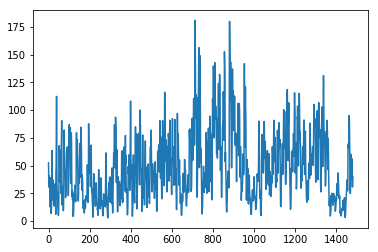

In [25]:
### gaps in the data have been dropped as well
plt.plot(Y_CR9)

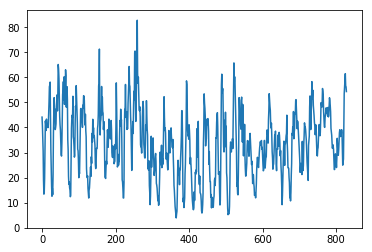

In [26]:
plt.plot(Y_CR7)

In [27]:
### define function for Ridge regression + cross-validation
def fit_ridge(X,Y):
    alpha_i = [0,1e-25,3e-25,1e-24,3e-24,1e-23,3e-23,1e-22,3e-22,1e-21,3e-21,1e-20,3e-20,1e-19,3e-19,1e-18,3e-18,1e-17,3e-17,1e-16,3e-16,1e-15,3e-15,1e-14,3e-14,1e-13,3e-13,1e-12,3e-12,1e-11,3e-11,1e-10,3e-10,1e-9,1e-8,1e-7,1e-6,1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,0.1,0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1e6,3e6,1e7,3e7,1e8,3e8,1e9,3e9,1e10]
    parameters = {
        'alpha': alpha_i,
        'fit_intercept': [True,False],
        'max_iter':[1000],
        'random_state':[100]
                 }    
    cv_obj = KFold(n_splits=5)
    regr = GridSearchCV(Ridge(normalize=True),parameters,cv=cv_obj,n_jobs=8,refit=True)
    regr.fit(X, Y)
    print(regr.best_estimator_.alpha,'alpha')
    return regr

In [28]:
### define corresponding MLR
def fit_ridge_alphazero(X,Y):
    alpha_i = [0]
    parameters = {
        'alpha': alpha_i,
        'fit_intercept': [True,False],
        'max_iter':[1000],
        'random_state':[100]
                 }    
    cv_obj = KFold(n_splits=5)
    regr = GridSearchCV(Ridge(normalize=True),parameters,cv=cv_obj,n_jobs=8,refit=True)
    regr.fit(X, Y)
    print(regr.best_estimator_.alpha,'alpha')
    return regr

In [29]:
### define function for Random Forest regression
def fit_RF(X,Y):
    parameters = {
        'n_estimators': [200],
        'min_samples_split': [2,3,4,5,7,9,12,15,18,21,24,27,30,35,40,50],
        'min_samples_leaf': [1,2,3,4,5,6,8,10,15,20],
        'random_state':[100]
                 }

    cv_obj = KFold(n_splits=5)
    regr = GridSearchCV(RandomForestRegressor(),parameters,cv=cv_obj,n_jobs=8,refit=True)
    regr.fit(X, Y)
    print(regr.best_estimator_)
    return regr

In [30]:
### and for Gaussian Process reression
def fit_GP(X,Y):
    kernel = 10 * RBF(1, (1e-2, 1e2)) + WK(1) +M() + DotProduct()
    gp = GPR(kernel=kernel)
    parameters = {
        'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,20,25,30,40,50,60,70,80,90,100,150,200,250,300],
        'n_restarts_optimizer': [25],
        'normalize_y': [True],
                    }
    cv_obj = KFold(n_splits=5)
    regr = GridSearchCV(gp,parameters,cv=cv_obj,n_jobs=8,refit=True)
    scaler_x = StandardScaler().fit(X)
    X_norm = scaler_x.transform(X)    
    regr.fit(X_norm, Y)
    print(regr.best_estimator_)
    return regr, scaler_x

In [ ]:
# fit models for CR9 to predict at CarPark
model_ridge_CR9 = fit_ridge(X_CR9,Y_CR9)
model_LR_CR9 = fit_ridge_alphazero(X_CR9,Y_CR9)
model_RF_CR9 = fit_RF(X_CR9,Y_CR9)
model_GP_CR9, scaler_x_CR9 = fit_GP(X_CR9,Y_CR9)

In [ ]:
# fit models at CR7 to predict on CR9
model_ridge_CR7 = fit_ridge(X_CR7,Y_CR7)
model_LR_CR7 = fit_ridge_alphazero(X_CR7,Y_CR7)
model_RF_CR7 = fit_RF(X_CR7,Y_CR7)
model_GP_CR7, scaler_x_CR7 = fit_GP(X_CR7,Y_CR7)

/home/peer/Documents/AirPublic/Peer_Pack/code/data_analysis/data-analysis/functions_lev_peer.py:325: RuntimeWarning: invalid value encountered in greater_equal
  alert_triggered = ((this_hour_over_alert_threshold + hour_minus_one_over_alert_threshold + hour_minus_two_over_alert_threshold) >= 2)


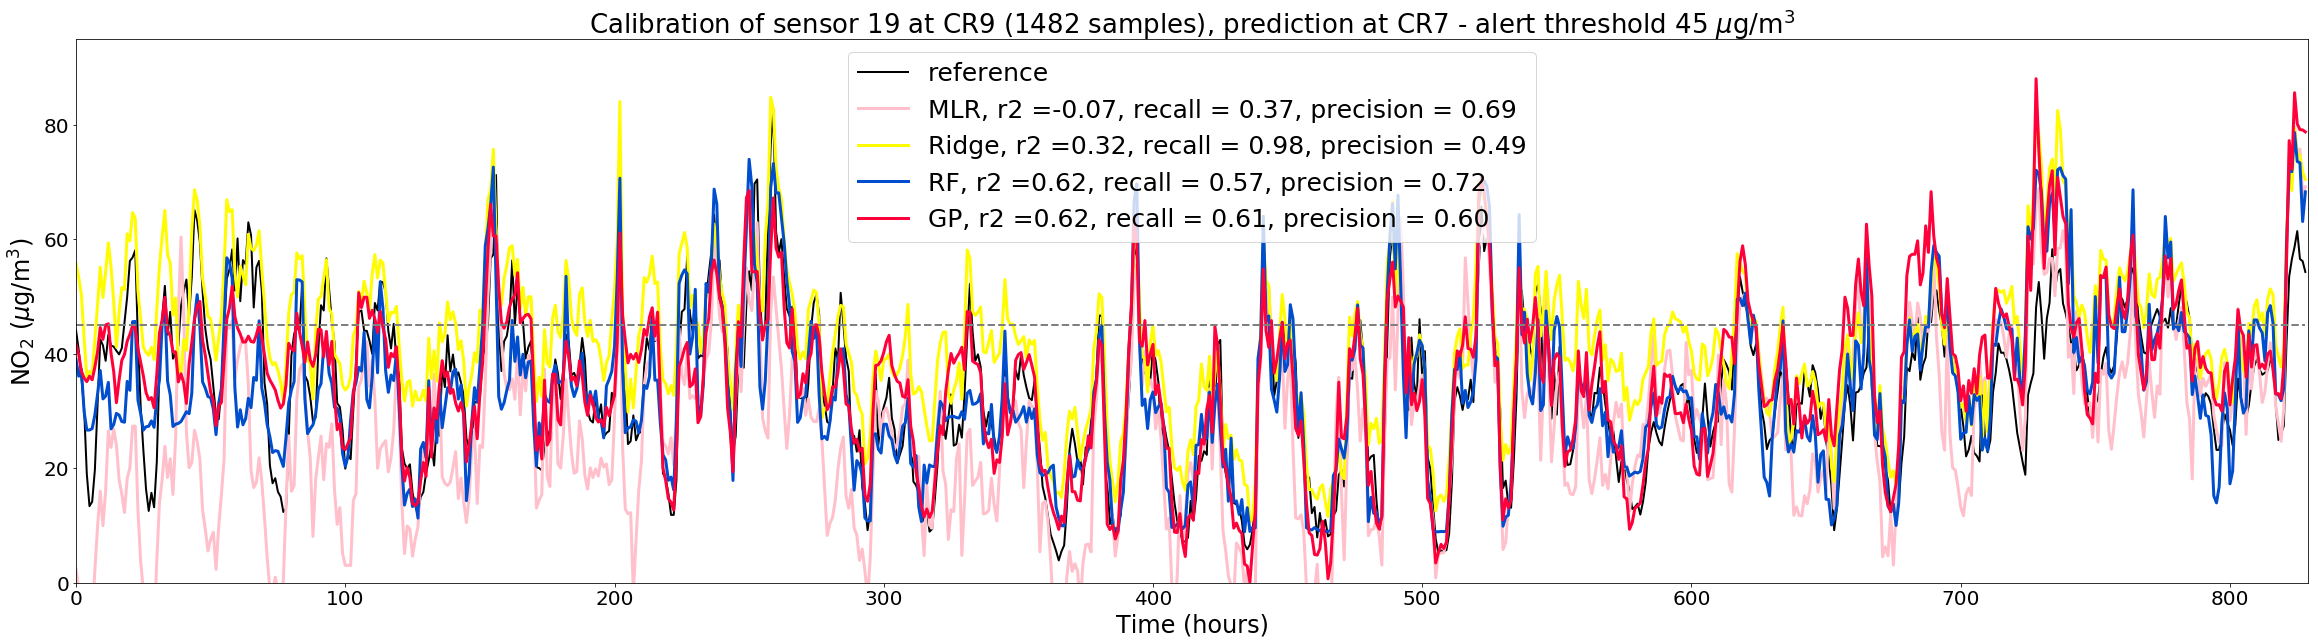

In [47]:
# model CR9 predict on alphasense
plt.rcParams['figure.figsize'] = (40,10)
from matplotlib import cm
alert_threshold=45.0
clevels = np.linspace(0,1,10)
y_pred_at_alphasense_ridgeCR9 = model_ridge_CR9.predict(X_CR7)
y_pred_at_alphasense_LRCR9 = model_LR_CR9.predict(X_CR7)
y_pred_at_alphasense_RFCR9 = model_RF_CR9.predict(X_CR7)
y_pred_at_alphasense_GPCR9 = model_GP_CR9.predict(scaler_x_CR9.transform(X_CR7))
r2_ridge = round(r2_score(Y_CR7,y_pred_at_alphasense_ridgeCR9),2)
r2_LR = round(r2_score(Y_CR7,y_pred_at_alphasense_LRCR9),2)
r2_RF = round(r2_score(Y_CR7,y_pred_at_alphasense_RFCR9),2)
r2_GP = round(r2_score(Y_CR7,y_pred_at_alphasense_GPCR9),2)
y_alerts = lp.add_alerts_to_np_array(Y_CR7,alert_threshold=alert_threshold)
y_alerts_ridge = lp.add_alerts_to_np_array(y_pred_at_alphasense_ridgeCR9,alert_threshold=alert_threshold)
y_alerts_LR = lp.add_alerts_to_np_array(y_pred_at_alphasense_LRCR9,alert_threshold=alert_threshold)
y_alerts_RF = lp.add_alerts_to_np_array(y_pred_at_alphasense_RFCR9,alert_threshold=alert_threshold)
y_alerts_GP = lp.add_alerts_to_np_array(y_pred_at_alphasense_GPCR9,alert_threshold=alert_threshold)
recall_ridge = round(recall_score(y_alerts,y_alerts_ridge,average='binary',pos_label=1),2)
recall_LR = round(recall_score(y_alerts,y_alerts_LR,average='binary',pos_label=1),2)
recall_RF = round(recall_score(y_alerts,y_alerts_RF,average='binary',pos_label=1),2)
recall_GP = round(recall_score(y_alerts,y_alerts_GP,average='binary',pos_label=1),2)
prec_ridge = round(precision_score(y_alerts,y_alerts_ridge,average='binary',pos_label=1),2)
prec_LR = round(precision_score(y_alerts,y_alerts_LR,average='binary',pos_label=1),2)
prec_RF = round(precision_score(y_alerts,y_alerts_RF,average='binary',pos_label=1),2)
prec_GP = round(precision_score(y_alerts,y_alerts_GP,average='binary',pos_label=1),2)
nt_alphasense = len(Y_CR7)
plt.plot(np.arange(0,nt_alphasense),Y_CR7,linewidth=2,color='k',label='reference')
plt.plot(np.arange(0,nt_alphasense),y_pred_at_alphasense_LRCR9,linewidth=3,color='pink',label='MLR, r2 ='+str("%.2f" % r2_LR)+', recall = '+str("%.2f" % recall_LR)+', precision = '+str("%.2f" % prec_LR))
plt.plot(np.arange(0,nt_alphasense),y_pred_at_alphasense_ridgeCR9,linewidth=3,color=cm.prism(clevels[2]),label='Ridge, r2 ='+str("%.2f" % r2_ridge)+', recall = '+str("%.2f" % recall_ridge)+', precision = '+str("%.2f" % prec_ridge))
plt.plot(np.arange(0,nt_alphasense),y_pred_at_alphasense_RFCR9,linewidth=3,color=cm.prism(clevels[4]),label='RF, r2 ='+str("%.2f" % r2_RF)+', recall = '+str("%.2f" % recall_RF)+', precision = '+str("%.2f" % prec_RF))
plt.plot(np.arange(0,nt_alphasense),y_pred_at_alphasense_GPCR9,linewidth=3,color=cm.prism(clevels[6]),label='GP, r2 ='+str("%.2f" % r2_GP)+', recall = '+str("%.2f" % recall_GP)+', precision = '+str("%.2f" % prec_GP))
plt.plot(np.arange(0,nt_alphasense),alert_threshold*np.ones((nt_alphasense)),linewidth=2,color='gray',linestyle='--')
plt.title(r'Calibration of sensor 19 at CR9 (1482 samples), prediction at CR7 - alert threshold 45 $\mu$g/m$^3$',size=26)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Time (hours)',size=24)
plt.ylabel(r'NO$_2$ ($\mu$g/m$^3$)',size=24)
plt.ylim(0,95)
plt.xlim(0,829)
plt.legend(prop={'size': 25})
plt.savefig('NO2_CR9_to_CR7_I30_1482samples.pdf',dpi=300)